## INFO284 - Group exam

Your tasks are:

#### Preprocessing: 
Get to understand the data and remove columns and rows that you do not find useful for your machine learning models. It is possible to for example focus on one type of gear, one or a few species, group categories of species, etc. etc. This will help to reduce
the data set you are working on. Understanding data and preparing them for model building
is a main task of machine learning.

#### Supervised learning: 
Build at least three machine learning models to predict or classify catch
data related to a fishery operation, i.e. species caught, amounts of one fish species (sums of amounts is also possible), or other features related to fish catches. One of the models needs to be a deep learning model.

#### Unsupervised learning: 
Build a clustering model for the data set. You may use a different preprocessing for this task than for the data in task b).


You shall deliver code in the form of a well commented Jupyter notebook. This code needs to run on the original data set, so any preprocessing you choose to do needs to be programmed in Python and included in the notebook. The code shall in the end return the results of your experiments with your chosen models. You need to explain

- Important and relevant properties of the data
- how you preprocessed data like which features you selected, did you do dimension reduction 
- how you reformatted data, etc.
- how you decided on parameters for your machine learning models,
- if you used any regularization techniques? In case how.
- how the methods were measured and compared

Please inform about any special Python libraries that need to be installed to make your code runnable.

Finally, as a concluding comment in the Jupyter notebook, you need to write a summary of your results, and discuss consequences of such results.

It is not necessarily so that high scores for machine learning models will give a good grade on your report, or vice versa, low scores a bad grade. What counts is a well-argued, well described, and smart machine learning investigation from start to end. The problem may in fact be of such nature that it is not possible to get really good results on these data.
Final note: These data are prepared for this course and are shared with you in confidence that you do not share them in any way but use them only for the purpose of this exam.


# 1: Preprocessing


## 1: Importerer nødvendige biblioteker
Legge inn en kort analyse av csv-filen
Leser csv.

In [229]:
import pandas as pd
import numpy as np
from sklearn import linear_model  # For den lineære modellen.
from sklearn.model_selection import train_test_split  # For å splitte datasettet.
import datetime as dt
import matplotlib.pyplot as plt  # For statistikk og grafiske fremstillinger.
import seaborn as sns  # For statistikk og grafiske fremstillinger
from sklearn.tree import DecisionTreeRegressor
import time

from sklearn.preprocessing import StandardScaler # For KNN-regressor
from sklearn.neighbors import KNeighborsRegressor # For kNN-regressor
from sklearn.metrics import mean_squared_error # For å måle resultat

df = pd.read_csv("GroupExam2024_data_and_documentation/elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv", sep=';', decimal=',')

## 2: Splitte datasett
Legge inn litt om hvorfor

In [230]:
# Splitter datasettet i train_df og test_df
train_df, test_df = train_test_split(df, test_size = 0.15)

## 3: Utforske datasettet:
Skrive litt om hva vi tenker å gjøre?

In [231]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 259618 entries, 19704 to 84338
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Melding ID                259618 non-null  int64  
 1   Meldingstidspunkt         259618 non-null  object 
 2   Meldingsdato              259618 non-null  object 
 3   Meldingsklokkeslett       259618 non-null  object 
 4   Starttidspunkt            259618 non-null  object 
 5   Startdato                 259618 non-null  object 
 6   Startklokkeslett          259618 non-null  object 
 7   Startposisjon bredde      259618 non-null  float64
 8   Startposisjon lengde      259618 non-null  float64
 9   Hovedområde start (kode)  257904 non-null  float64
 10  Hovedområde start         256109 non-null  object 
 11  Lokasjon start (kode)     257904 non-null  float64
 12  Havdybde start            259618 non-null  int64  
 13  Stopptidspunkt            259618 non-null  obj

Av df.info ser vi de ulike kolonnene og hvilken datatype de er. og hvor mange "non-null" verdier som eksisterer. Kan se her at det eksisterer null-verdier i de fleste kolonner. Dette renses senere. Konverterer datatype etter å ha filtrert ut de uaktuelle kolonnene.

Basert på datasettet og kolonnene vi har sett på så ønsker vi å predikere rundvekt av en aktivitet.


Ser av datasettet hvordan dataen er strukturert. 
**Organisering av datasettet**
Hver rad representerer en fangst av art. Flere rader er registrert med samme starttidspunkt eller stopptidspunkt. De ulike fangstene som er gjort på samme tidspunkt med samme melding ID kommer fra samme fiskeaktivitet. Videre så har de ulike aktivitetene som er gjort på samme Melding ID samme meldingsdato, og kommer fra samme båt.

**Bruttotonnasje 1969 og Bruttotonnasje annen**
Vi ser også at kolonnen Bruttotonnasje annen og bruttotonnasje 1969 ser ut til å utfylle hverandre.Med bruttotonnasje menes det totale volumet av hulrom i båten. Det kan ikke helt sammenlignes med lastekapasitet, men kan være en indikator. Bruttotonnasje 1969 er standarden i dag for registrering av dette målet av båten. Bruttotonnasje annen viser de båtene som er registrert gjennom andre systemer enn standarden.

Vi antar at selv om det antakelig er forskjeller i hvordan disse båtene har målt sin Bruttotonnasje, så er det sannsynligvis også så mange likheter at det ikke har betydning. Dette er det kanskje nødvendig å undersøke nermere dersom man vil ha en mer nøyaktig analyse av dataene. Disse to kolonnene vil vi derfor slå sammen. til en felles kolonne.

Hva leter vi etter?
Siden dette er en samling av fiskeridata, så tenker vi det er interessant å se nærmere på fangstdataene. Her kunne vi hatt mange interessante innfallsvinkler, men vi ønsker å se om det er mulig å predikere rundvekt av en bestemt art gitt den informasjonen vi har. Siden fiskere bruker ulike redskaper for å fange fisk kan vi kan anta at noen redskaper og metoder er mer egnet for å fange bestemte arter. For eksempel så brukes ikke teiner for å fange torsk eller trål for å fange makrell (Må sjekke opp i). I tillegg vet vi også at det foregår fiske etter ulike arter på ulike steder og tidspunkt. Skreifiske for eksempel foregår i bestemte tidsrom etter bestemte arter, med bestemte redskaper. Videre kan vi anta at det samme gjelder for for eksempel sildefiske. Kunnskap om hvordan, hvor og hva som fiskes etter er derfor viktig for å forstå datasettet. Videre avsnitt bruker vi på å undersøke informasjon omkring fisket.


In [232]:
# Først undersøker vi hvor mange registreringer det er av de ulike fisketypene og hvor mye det fiskes av hver.

species_weight_sum = train_df.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(train_df['Art - gruppe'].value_counts())
print(species_weight_sum)

Art - gruppe
Torsk                                       48272
Annen torskefisk                            38324
Sei                                         36135
Hyse                                        33348
Annen flatfisk, bunnfisk og dypvannsfisk    21519
Uer                                         16698
Steinbiter                                  13798
Dypvannsreke                                11615
Blåkveite                                    6850
Snøkrabbe                                    5135
Sild, annen                                  5091
Skater og annen bruskfisk                    3445
Makrell                                      2556
Kolmule                                      2400
Øyepål                                       1863
Annen pelagisk fisk                          1541
Vassild og strømsild                         1411
Andre skalldyr, bløtdyr og pigghuder         1126
Lodde                                        1025
Tobis og annen sil                   

Her ser vi en hovedvekt av fiske etter Torsk. På en annenplass kommer sei. Reke er det også mye aktivitet rundt.

In [233]:
# Gjør samme undersøkelse av reskaper.

redskap_weight_sum = train_df.groupby('Redskap FDIR')['Rundvekt'].sum().sort_values(ascending=False)
print(train_df['Redskap FDIR'].value_counts())
print(redskap_weight_sum)

Redskap FDIR
Bunntrål                                  102631
Snurrevad                                  43919
Andre liner                                37329
Reketrål                                   18960
Udefinert garn                             16374
Udefinert trål                             13484
Snurpenot/ringnot                          10742
Teiner                                      5758
Bunntrål par                                2845
Dobbeltrål                                  2401
Flytetrål                                   2343
Flytetrål par                               1281
Settegarn                                    554
Harpun og lignende uspesifiserte typer       420
Annet                                        387
Juksa/pilk                                    15
Dorg/harp/snik                                14
Name: count, dtype: int64
Redskap FDIR
Snurpenot/ringnot                         648309149.0
Flytetrål                                 401789343.0
Bunntrå

Her ser vi at de to mest brukte fangstredskapene er Bunntrål og Snurrevad. Videre er andre liner, reketrål og andre liner høyt oppe på listen. fra fiskeridirektoratet (kilde) vet vi at Bunntrål og Snurrevad er garn/not som blir slept langs bunnen av sjøen og samler opp fisk på den måten. Andre liner (dersom vi har forstått det riktig) er fiske med agn og krok som gjerne slepes bak båten. 

Det som er naturlig å undersøke nå er hvordan sammensetningen av fisk er med de ulike fangsmetodene, og hvor det er vanlig at de blir brukt.

In [234]:
# Ser etter hvilke fisk som blir fisket med Bunntrål:
condition = train_df[train_df['Redskap FDIR'] == 'Bunntrål']
species_weight_sum = condition.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(condition['Art - gruppe'].value_counts(), species_weight_sum)

Art - gruppe
Torsk                                       19958
Sei                                         15537
Hyse                                        14216
Annen torskefisk                            12712
Uer                                         12104
Annen flatfisk, bunnfisk og dypvannsfisk     7322
Dypvannsreke                                 6337
Steinbiter                                   6198
Blåkveite                                    4342
Skater og annen bruskfisk                     695
Øyepål                                        608
Andre skalldyr, bløtdyr og pigghuder          528
Vassild og strømsild                          404
Kolmule                                       398
Annen pelagisk fisk                           340
Sild, annen                                   275
Makrell                                       194
Tobis og annen sil                            153
Haifisk                                        58
Lodde                                

In [235]:
# Ser etter hvilke fisk som blir fisket med Snurrevad:
condition = train_df[train_df['Redskap FDIR'] == 'Snurrevad']

species_weight_sum = condition.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(condition['Art - gruppe'].value_counts(), species_weight_sum)

Art - gruppe
Torsk                                       13962
Hyse                                        10141
Sei                                          9571
Annen flatfisk, bunnfisk og dypvannsfisk     3590
Annen torskefisk                             3471
Steinbiter                                   1091
Uer                                           687
Blåkveite                                     323
Sild, annen                                    26
Makrell                                        18
Skater og annen bruskfisk                       9
Dypvannsreke                                    8
Lodde                                           7
Andre skalldyr, bløtdyr og pigghuder            3
Haifisk                                         3
Sjøpattedyr                                     1
Annen pelagisk fisk                             1
Name: count, dtype: int64 Art - gruppe
Torsk                                       50168477.0
Sei                                        

In [236]:
# Ser etter hvilke fisk som blir fisket med andre liner:
condition = train_df[train_df['Redskap FDIR'] == 'Andre liner']
species_weight_sum = condition.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(condition['Art - gruppe'].value_counts(), species_weight_sum)

Art - gruppe
Annen torskefisk                            9467
Torsk                                       6264
Steinbiter                                  5733
Hyse                                        5659
Uer                                         2759
Sei                                         2109
Annen flatfisk, bunnfisk og dypvannsfisk    1959
Blåkveite                                   1784
Skater og annen bruskfisk                   1524
Haifisk                                       50
Kongekrabbe, annen                             3
Brunalger                                      1
Name: count, dtype: int64 Art - gruppe
Torsk                                       28292692.0
Hyse                                        21265107.0
Annen torskefisk                            17717599.0
Steinbiter                                   4049229.0
Blåkveite                                    2735353.0
Sei                                           772490.0
Skater og annen bruskfisk     

In [237]:
# Ser etter hvilke fisk som blir fisket med reketrål:
condition = train_df[train_df['Redskap FDIR'] == 'Reketrål']
species_weight_sum = condition.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(condition['Art - gruppe'].value_counts(), species_weight_sum)

Art - gruppe
Dypvannsreke                                4940
Annen flatfisk, bunnfisk og dypvannsfisk    3354
Annen torskefisk                            2795
Torsk                                       2508
Sei                                         2325
Skater og annen bruskfisk                   1016
Hyse                                         432
Øyepål                                       382
Andre skalldyr, bløtdyr og pigghuder         280
Annen pelagisk fisk                          168
Uer                                          153
Steinbiter                                   151
Blåkveite                                    109
Vassild og strømsild                         103
Kolmule                                      101
Sild, annen                                   25
Makrell                                       20
Haifisk                                       16
Tobis og annen sil                             7
Mesopelagisk fisk                              2
Brunalg

In [238]:
# Ser etter hvilke fisk som blir fisket med snurpenot, ringnot et fartøy:
condition = train_df[train_df['Redskap FDIR'] == 'Snurpenot/ringnot']
species_weight_sum = condition.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(condition['Hovedart FAO'].value_counts(), species_weight_sum)

Hovedart FAO
Sild                    4684
Sei                     1091
Lodde                   1070
Makrell                  806
Torsk                    625
Brisling                 143
Tobis og annen sil       125
Hestmakrell               80
Kolmule                   51
Strømsild/Vassild         20
Strømsild                 19
Hyse                       6
Vassild                    4
Makrellstørje              2
Blåkveite                  2
Nordlig lysprikkfisk       1
Name: count, dtype: int64 Art - gruppe
Sild, annen                                 299404081.0
Lodde                                       152355231.0
Makrell                                     135235410.0
Sei                                          29280383.0
Kolmule                                      19159950.0
Tobis og annen sil                            5014001.0
Torsk                                         3869648.0
Kystbrisling                                  2189800.0
Annen pelagisk fisk                 

Etter å ha studert de ulike redskapene og hva som blir fisket med de aktuelle, ser vi også konturene av hvordan de blir brukt. Bunntrål er den mest ukritiske fangstmetoden og den tar med seg et større mangfold av fisk enn for eksempel snurrevad som kanskje er naturlig å sammenligne med. Man skulle tro av navnet at en reketrål var mer målrettet i fangsten, og at andelen reker var større i denne sammensetningen, men her kan vi også anta, at siden reker står ganske lavt i næringskjeden, så vil det være naturlig at det er en stor andel av "rovfisker" i miksen. Vi har ikke sett her hvor stor andel av vekten de andre fiskene utgjør

Redskaper:
    Snurpenot/ringnot:
        Dette er det redskapet som det blir fisket desidert mest fisk med, selv om det er mye flere registreringer av andre redskaper. Forklaring her kan være at at med Snurpenot/ringnot blir det fisket mest stimfisk som sild, lodde, makrell osv, som opptrer i stim og dermed er naturlig at man fanger mye av når man først har funnet stimen. Det trenger ikke nødvendigvis bety at det er et mer effektivt fiske.
    Bunntrål:
        Med dette redskapet blir det fisket mest torsk og sei, men også ganske mye av andre arter. Det er det redskapet som vi har undersøkt som har jevnest fordeling arter, som betyr at det er det redskapet som bidrar med mest bifangst.
    Snurrevad:
        Dette redskapet ligner på bunntrål, men det virker som det drives litt mer målrettet fiske med dette. Spredningen av fangst av forskjellige arter er ikke så stor.
    Andre liner:
    Reketrål:
    
Basert på denne infoen er det interessant å dykke videre inn i et bestemt redskap og art og muligens et bestemt område. 


In [239]:
print(train_df['Hovedområde start'].value_counts())

Hovedområde start
Eigersundbanken                  38577
Røstbanken til Malangsgrunnen    24715
Vest-Finnmark                    23520
Øst-Finnmark                     22978
Bjørnøya                         21517
Shetland                         20968
Nordkappbanken                   15879
Vikingbanken                     14048
Skagerrak                        13688
Storegga-Frøyabanken             12592
Helgelandsbanken                  7324
Sentralbanken                     4711
Storbanken                        4117
Thor Iversens Bank                3890
Vestfjorden (Lofoten)             3869
Sentrale Nordsjø                  2879
Hopen                             2686
Vest av Skottland (Hebridene)     1699
Sørlige Norskehav                 1689
Østlige Norskehav                 1657
Skolpenbanken                     1627
Admiralityfeltet                  1623
Gåsebanken                        1454
Storfjord/Hinlopenstredet         1179
Vest-Spitsbergen                  1057
Vest av

Lokasjon:
Det er ingen hemmelighet at fiske etter ulike arter foregår på ulike steder til ulikt tidspunkt, avhengig av hva man ønsker å fiske, og hvor mye. For eksempel har skreifiske i lofoten pågått i tusener av år. Storsilden har også tradisjonelt sett kommet inn til vestlandskysten på vinteren.
https://open-data-fiskeridirektoratet-fiskeridir.hub.arcgis.com/datasets/1b8c3425aaf643e9b2abd3bc70111697/explore

Sei:
Vi har valgt å fokusere på seifiske: I Norge er det hovedsaklig fiske etter to grupper av sei. En gruppe som beiter i havområdene mellom Norge og Skottland https://www.hi.no/hi/temasider/arter/sei-i-nordsjoen og en annen som beiter i kystområdene fra vestlandet til finnmark. https://www.hi.no/hi/temasider/arter/nordaustarktisk-sei.
De er rovfisker og vandrefisk og kan følge sild langt ut i norskehavet. 

Om vi skal fokusere på den nordøstarktiske seien, kan det se ut fra denne informasjon at det kan være lurt å fokusere på hovedområdene fra 0-7 og 28 men uten hovedområde 2. Om vi skal inkludere Nordsjøseien, så kan vi inkludere områdene 40-43, men da beveger vi oss også litt utenfor de de norske områdene.

Videre er det 

Kart over hovedområder. Brukes for å velge ut aktuelle områder.
https://open-data-fiskeridirektoratet-fiskeridir.hub.arcgis.com/datasets/1b8c3425aaf643e9b2abd3bc70111697/explore 



## 4: Filtrere data:

In [240]:
# Lager en betingelse med aktuelle områder.
northeastern = [0, 1, 3, 4, 5, 6, 7, 28]
northeastern_ocean = [30, 34, 37, 39, 12, 36] # For å undersøke om det er noe særlig seifiske utenfor de mer kystnære strøk
northsea = [40, 41, 42, 43] # For å undersøke seifiske
# Legger inn betingelser i train_df.
filtered_train_df = train_df[
    (train_df['Hovedart FAO'] == 'Sei') &
    (train_df['Hovedområde start (kode)'].isin(northeastern)) &
    (train_df['Redskap FDIR'] == 'Bunntrål')
]

# Gjør det samme med test-settet
filtered_test_df = test_df[
    (test_df['Hovedart FAO'] == 'Sei') &
    (test_df['Hovedområde start (kode)'].isin(northeastern)) &
    (test_df['Redskap FDIR'] == 'Bunntrål')
]

filtered_train_df.describe()  # Får her et inntrykk av ekstremverdier og gjennomsnitt.

,Melding ID,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Lokasjon start (kode),Havdybde start,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,...,Redskap FDIR (kode),Hovedart - FDIR (kode),Art - FDIR (kode),Art - gruppe (kode),Rundvekt,Lengdegruppe (kode),Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
count,2.300700e+04,23007.000000,23007.000000,23007.000000,23007.000000,23007.000000,23007.000000,23007.0,23007.000000,23007.000000,...,23007.0,23007.0,23007.000000,23007.000000,23007.000000,23007.000000,22303.000000,704.000000,23007.000000,23007.000000
mean,1.646252e+06,66.712978,12.984217,8.597514,19.155301,-188.758421,255.494545,2018.0,66.730461,13.018956,...,51.0,1032.0,1234.518451,224.896553,2679.949624,4.935194,1953.690311,165.958807,12.914385,57.226416
std,9.420759e+04,4.125015,8.325329,8.289162,13.866316,64.335182,89.215090,0.0,4.135871,8.344127,...,0.0,0.0,451.449362,39.703524,5361.271145,0.284214,1074.934674,16.124066,2.264553,15.148306
min,1.497341e+06,60.001000,2.005000,0.000000,1.000000,-761.000000,6.000000,2018.0,59.647000,1.654000,...,51.0,1032.0,529.000000,201.000000,0.000000,3.000000,197.000000,129.000000,6.980000,19.750000
25%,1.549221e+06,62.839500,5.326500,4.000000,9.000000,-226.000000,195.000000,2018.0,62.843000,5.340000,...,51.0,1032.0,1023.000000,202.000000,76.000000,5.000000,1199.000000,173.000000,12.200000,50.800000
50%,1.665167e+06,68.000000,10.849000,5.000000,15.000000,-183.000000,266.000000,2018.0,68.030000,10.933000,...,51.0,1032.0,1032.000000,203.000000,259.000000,5.000000,1598.000000,173.000000,13.000000,56.800000
75%,1.728872e+06,70.868000,20.558000,7.000000,23.000000,-145.000000,321.000000,2018.0,70.883000,20.591000,...,51.0,1032.0,1034.000000,220.000000,2413.000000,5.000000,2610.000000,173.000000,14.600000,69.900000
max,1.800286e+06,71.998000,32.279000,28.000000,54.000000,1.000000,1706.000000,2018.0,72.060000,32.226000,...,51.0,1032.0,2919.000000,520.000000,86506.000000,5.000000,4427.000000,173.000000,16.700000,81.200000


## 5: Gruppere data:
Vi har valgt å gruppere data etter aktiviteter etter å ha sett igjennom data først. Man kan argumentere for at det ville vært lurt å gjort det før i prosjektet, men mulige utfordringer da er å ikke kunne fange opp nyansene i datasettet. 

For eksempel så er det slik at på en aktivitet så er det registrert flere arter og rundvekt av hver art. Dersom man ikke har et bilde av hvordan fordelingen av rundvekt er, så kan man senere få utfordringer med modellen. Vi er bevisst på at når vi slår disse aktivitetene sammen, så beregner vi også rundvekten for hele fangsten ikke bare rundvekten av hovedarten.

Vi gjør derfor en antakelse om at rundvekt gir oss en pekepinn på hva en god fangst er, uavhengig av hvilke arter som er fanget, selv om vi ikke vet helt sikkert at det er slik. Kanskje er målrettet fiske mer lønnsomt. Men når man fisker med trål så er mangfoldet av arter som man fanger en del av bildet.

Skal man predikere fangst basert på redskapet trål, så blir det, gitt omfanget av oppgaven, naturlig å regne rundvekt basert på hele fangsten, men med fokus på en bestemt art.

In [241]:
# Funksjon for å samle de sammenslåtte dataene som tekststreng.
def join_unique_values(series):
    return ', '.join(series.dropna().astype(str).unique())

grouped_df = filtered_train_df.groupby(['Melding ID', 'Stoppklokkeslett'], as_index=False).agg({
    'Melding ID': 'first', #Trengs muligens for å skille ulike tokter??
    'Meldingstidspunkt': 'first', 
    'Meldingsdato': 'first',
    'Meldingsklokkeslett': 'first', 
    'Starttidspunkt': 'first', 
    'Startdato': 'first',
    'Startklokkeslett': 'first', 
    'Startposisjon bredde': 'first', 
    'Startposisjon lengde': 'first',
    'Hovedområde start (kode)': 'first', 
    'Hovedområde start': 'first',
    #'Lokasjon start (kode)': 'first', # Mye tomme celler, dokumentasjonen advarer om å bruke denne kolonnen.
    'Havdybde start': 'first', 
    'Stopptidspunkt': 'first', 
    'Stoppdato': 'first', 
    'Stoppklokkeslett': 'first', 
    'Varighet': 'first', 
    #'Fangstår': 'first', Så og si alle fangstdata er registrert i 2018.
    'Stopposisjon bredde': 'first', 
    'Stopposisjon lengde': 'first',
    'Hovedområde stopp (kode)': 'first', 
    'Hovedområde stopp': 'first',
    #'Lokasjon stopp (kode)': 'first', # Unødvendig å ha med videre.
    'Havdybde stopp': 'first', 
    'Trekkavstand': 'first',
    #'Redskap FAO (kode)': 'first', 
    #'Redskap FAO': 'first', 
    'Redskap FDIR (kode)': 'first', # Vi forholder oss FDIR sine kolonner av redskaper.
    'Redskap FDIR': 'first', 
    #'Hovedart FAO (kode)': 'first', 
    #'Hovedart FAO': 'first',
    'Hovedart - FDIR (kode)': 'first', 
    #'Art FAO (kode)': join_unique_values, 
    #'Art FAO': join_unique_values,
    #'Art - FDIR (kode)': join_unique_values, 
    #'Art - FDIR': join_unique_values, 
    #'Art - gruppe (kode)': join_unique_values,
    #'Art - gruppe': join_unique_values, 
    'Rundvekt': 'sum', 
    'Lengdegruppe (kode)': 'first', 
    'Lengdegruppe': 'first',
    'Bruttotonnasje 1969': 'first', 
    'Bruttotonnasje annen': 'first', 
    'Bredde': 'first',
    'Fartøylengde': 'first'
    })

grouped_df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),...,Redskap FDIR (kode),Redskap FDIR,Hovedart - FDIR (kode),Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497341,01.01.2018 23:30,01.01.2018,23:30,01.01.2018 18:54,01.01.2018,18:54,61.283,2.074,28.0,...,51.0,Bunntrål,1032.0,3000.0,5.0,28 m og over,2053.0,NaN,13.0,75.5
1,1497435,02.01.2018 07:50,02.01.2018,07:50,31.12.2017 18:10,31.12.2017,18:10,68.261,10.842,5.0,...,51.0,Bunntrål,1032.0,23114.0,5.0,28 m og over,2580.0,NaN,14.6,64.0
2,1497435,02.01.2018 07:50,02.01.2018,07:50,01.01.2018 03:21,01.01.2018,03:21,68.256,10.828,5.0,...,51.0,Bunntrål,1032.0,11298.0,5.0,28 m og over,2580.0,NaN,14.6,64.0
3,1497435,02.01.2018 07:50,02.01.2018,07:50,01.01.2018 12:47,01.01.2018,12:47,68.491,11.567,5.0,...,51.0,Bunntrål,1032.0,5318.0,5.0,28 m og over,2580.0,NaN,14.6,64.0
4,1497435,02.01.2018 07:50,02.01.2018,07:50,01.01.2018 19:25,01.01.2018,19:25,68.318,11.036,5.0,...,51.0,Bunntrål,1032.0,18503.0,5.0,28 m og over,2580.0,NaN,14.6,64.0


/opt/homebrew/anaconda3/envs/info284/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


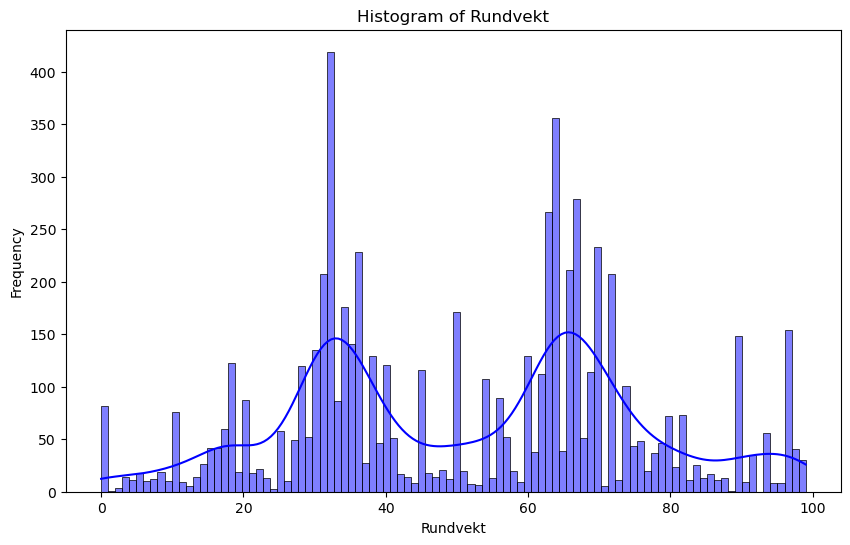

In [242]:
import seaborn as sns

rundvekt_df = filtered_train_df[filtered_train_df['Rundvekt'] < 100]

# Assuming 'data' is your DataFrame and 'rundvekt' is the column
plt.figure(figsize=(10, 6))
sns.histplot(rundvekt_df['Rundvekt'], kde=True, bins=100, color='blue')
plt.title('Histogram of Rundvekt')
plt.xlabel('Rundvekt')
plt.ylabel('Frequency')
plt.show()

### Bruttotonnasje:
"Bruttotonn er totalvolumet av alle lukkede rom som er i bruk på et skip." (https://snl.no/bruttotonn) Ideellt i denne oppgaven skulle vi gjerne hatt en kolonne med nettotonn, siden det er skipets lastekapasitet. Det er vanskelig å vite hvilke mål på skipet som er de beste for å anslå skipets lastekapasitet, men vi har landet på bruttotonnasje som det beste målet. 

For å bruke bruttotonnasje-kolonnene er vi nødt til å kombinere kolonnene "bruttotonnasje 1969" og "bruttotonnasje annen". I dokumentasjonen står det følgende om bruttotonnasje 1969:

I denne variabelen, «Bruttotonnasje 1969», er det i dag ført bruttotonnasje for fartøy med 
lengde (L) større eller lik 24 meter (L), målt og berekna i medhald av internasjonal 
konvensjon om måling av fartøy, 1969 (London-konvensjonen 1969).

dvs at skip under 24 m er ført i bruttotonnasje annen og de andre i 1969. Vi kan da trygt slå sammen kolonnene siden ingen er registrert på forskjellige måter.

In [243]:
# Slår sammen bruttotonnasje-gruppene.
grouped_df.loc[:, 'Bruttotonnasje kombinert'] = grouped_df['Bruttotonnasje 1969'].fillna(grouped_df['Bruttotonnasje annen'])

/opt/homebrew/anaconda3/envs/info284/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


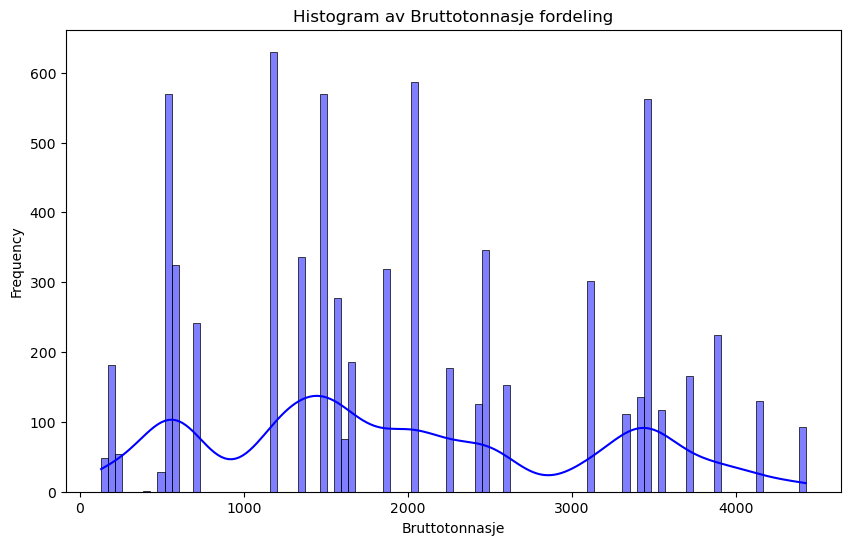

In [244]:
# Lager grafisk fremstilling av fordeling av båtstørrelse
plt.figure(figsize=(10, 6))
sns.histplot(grouped_df['Bruttotonnasje kombinert'], kde=True, bins=100, color='blue')
plt.title('Histogram av Bruttotonnasje fordeling')
plt.xlabel('Bruttotonnasje')
plt.ylabel('Frequency')
plt.show()

Ser her tendenser av at båtstørrelsen deles grovt inn i tre kategorier: Småbåter under 1000 bruttotonn, mellom store mellom 1000 og 3000 og store over 3000. vi velger å gruppere båtene inn i disse tre gruppene.

In [245]:
# Grupperer Bruttotonnasje-kolonnen
bins = [0, 1000, 2000, 3000, 4000]
labels = [1, 2, 3, 4]
grouped_df['Bruttotonnasje gruppert'] = pd.cut(grouped_df['Bruttotonnasje kombinert'], bins=bins, labels=labels)

grouped_df['Bruttotonnasje gruppert'].value_counts()

Bruttotonnasje gruppert
2    2393
4    1619
1    1449
3    1388
Name: count, dtype: int64

### Valg av kolonne i forhold til tid:
Etter å ha testet de ulike kolonnene hva gjelder fordeling av tid, ser vi at det er veldig mange registreringer på startklokkeslett 00.00


In [246]:
# Grupperer startklokkeslett i grupper etter timer slik at.
grouped_df['Startklokkeslett'] = pd.to_datetime(grouped_df['Startklokkeslett'], format='%H:%M')
grouped_df['Hours'] = grouped_df['Startklokkeslett'].dt.hour
print(grouped_df['Hours'].value_counts())

# Grupperer meldingsdato etter måneder.
grouped_df['Meldingsdato'] = pd.to_datetime(grouped_df['Meldingsdato'], format='%d.%m.%Y', errors='coerce')
grouped_df['Month'] = grouped_df['Meldingsdato'].dt.month
print(grouped_df['Month'].value_counts())

Hours
6     358
5     345
10    340
11    321
3     311
12    307
0     304
16    304
23    300
17    298
21    294
13    292
18    291
22    288
15    286
9     285
2     277
7     275
1     272
4     269
14    268
19    268
8     262
20    257
Name: count, dtype: int64
Month
2     1131
3      988
7      663
9      625
4      554
6      526
12     507
1      464
11     454
8      417
5      389
10     354
Name: count, dtype: int64


Sjekker månedlig fagst av sei i områdene

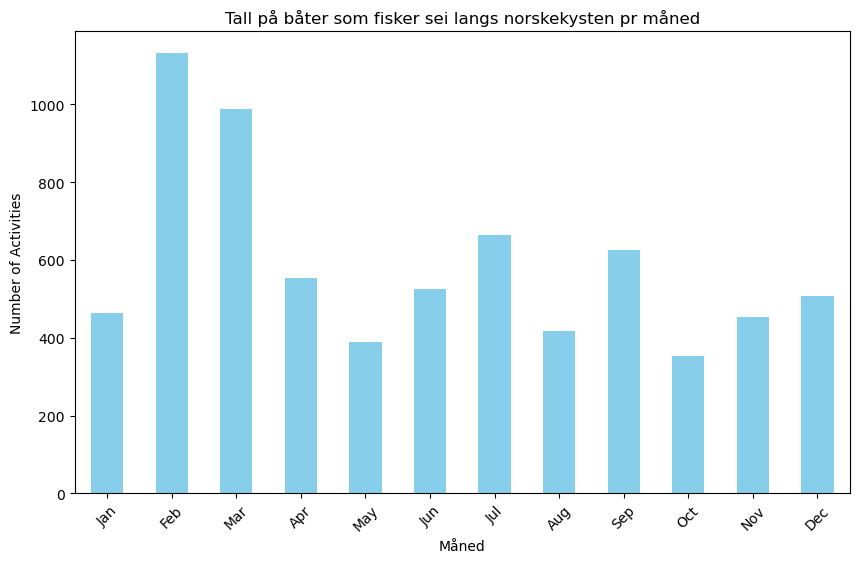

In [247]:
# Teller månedlig aktivitet.
monthly_counts = grouped_df.groupby('Month').size()

# Oppretter en serie for alle månedene i døgnet
all_months = pd.Series(0, index=range(1, 13))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_months.update(monthly_counts)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Tall på båter som fisker sei langs norskekysten pr måned')
plt.xlabel('Måned')
plt.ylabel('Number of Activities')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()


### aktiviteter pr måned
Vi ser her at det er mer aktivitet rundt seifiske i månedene februar og mars langs norskekysten. Det kan tenkes at dette har sammenheng med lofotfisket som foregår i månedene februar - april. 

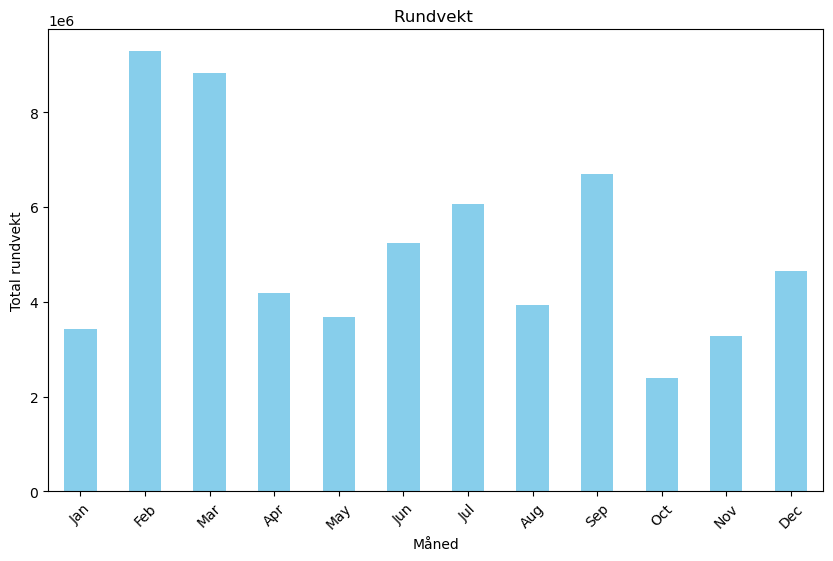

In [248]:
# Finner månedlig total rundvekt
monthly_weights = grouped_df.groupby('Month')['Rundvekt'].sum()

# Oppretter en serie for alle månedene i døgnet
all_months = pd.Series(0, index=range(1, 13))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_months.update(monthly_weights)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Rundvekt ')
plt.xlabel('Måned')
plt.ylabel('Total rundvekt')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

### Samlet rundvekt av aktivitetene pr måned
Her ser vi tydelig sammenheng mellom månedene med stor aktivitet og den samlede rundvekten av aktivitetene.

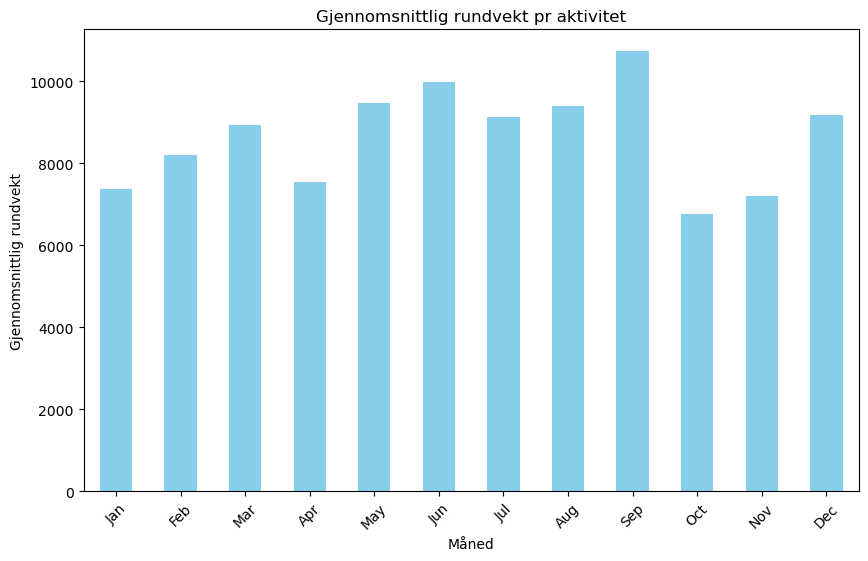

In [249]:
# Regner ut gjenomsnitt pr time
average_weights = monthly_weights/monthly_counts

# Oppretter en serie for alle timene i døgnet
all_months = pd.Series(0, index=range(1, 13))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_months.update(average_weights.astype(int))

# Generer et diagram
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Gjennomsnittlig rundvekt pr aktivitet')
plt.xlabel('Måned')
plt.ylabel('Gjennomsnittlig rundvekt')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

Ser her av gjennomsnittlig vekt at seifiske virker å være stabilt i den forstand at den forventede fangsten holder seg ganske stabil gjennom året.
September utmerker seg likevel som en måned hvor det er er forventet mer fisk.

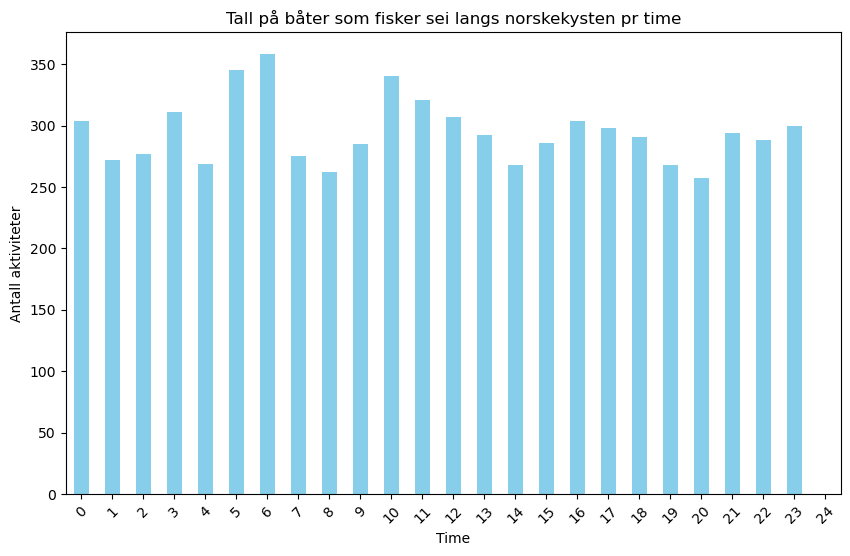

In [250]:
# Regner ut gjenomsnitt pr time
hourly_counts = grouped_df.groupby('Hours').size()

# Oppretter en serie for alle timene i døgnet
all_hours = pd.Series(0, index=range(0, 25))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_hours.update(hourly_counts)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_hours.plot(kind='bar', color='skyblue')
plt.title(f'Tall på båter som fisker sei langs norskekysten pr time')
plt.xlabel('Time')
plt.ylabel('Antall aktiviteter')
plt.xticks(range(25), [x for x in range (0,25)], rotation=45)
plt.show()


Her ser vi hvordan fiskeaktivitetene av sei varierer i løpet av døgnet. Ser at det er en nokså stabil aktivitet gjennom døgnet. Her hadde vi forventet litt variasjoner.

Det er nå interessant å se på forholdet mellom aktivitetene og fangsten.

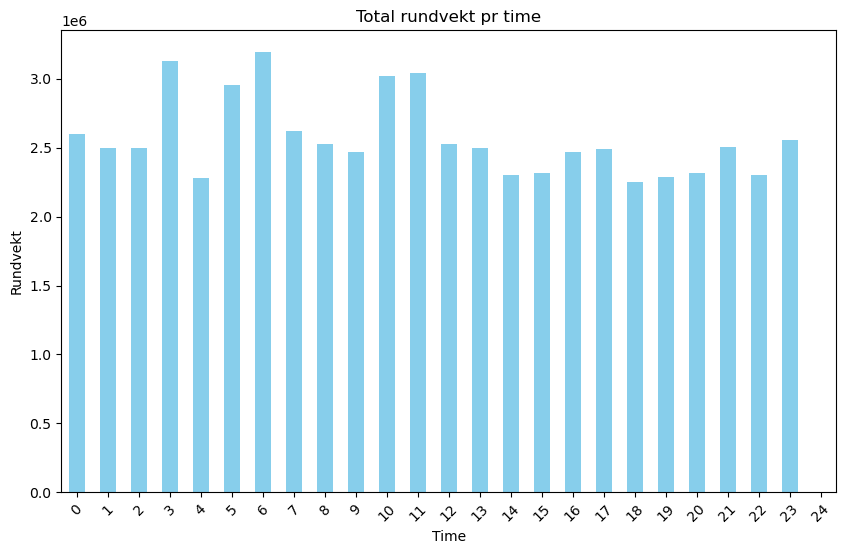

In [251]:
# Regner ut gjenomsnitt pr time
hourly_weights = grouped_df.groupby('Hours')['Rundvekt'].sum()

# Oppretter en serie for alle timene i døgnet
all_hours = pd.Series(0, index=range(0, 25))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_hours.update(hourly_weights)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_hours.plot(kind='bar', color='skyblue')
plt.title(f'Total rundvekt pr time')
plt.xlabel('Time')
plt.ylabel('Rundvekt')
plt.xticks(range(25), [x for x in range (0,25)], rotation=45)
plt.show()

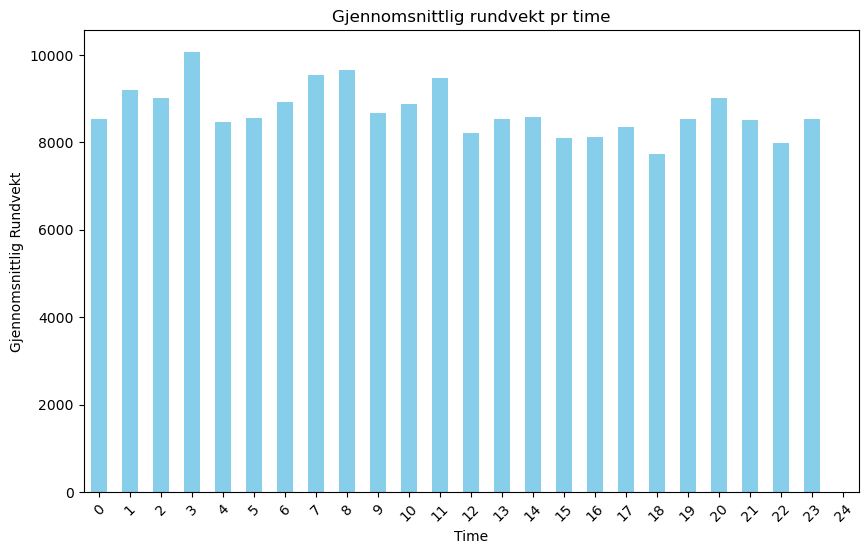

In [252]:
# Regner ut gjenomsnitt pr time
hourly_average = hourly_weights/hourly_counts

# Oppretter en serie for alle timene i døgnet
all_hours = pd.Series(0, index=range(0, 25))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_hours.update(hourly_average.astype(int))

# Generer et diagram
plt.figure(figsize=(10, 6))
all_hours.plot(kind='bar', color='skyblue')
plt.title(f'Gjennomsnittlig rundvekt pr time')
plt.xlabel('Time')
plt.ylabel('Gjennomsnittlig Rundvekt')
plt.xticks(range(25), [x for x in range (0,25)], rotation=45)
plt.show()

### Tolking av data:
Det ser ut som seifisket med bunntrål fordeler seg ganske jevnt ut over døgnet og året, men med litt mer variasjon i løpet av året, og med den beste fangsmåneden i september om man ser på gjennomsnittlig fangst. Om noe forskjell i løpet av døgnet, så ser det ut som det det blir fanget noe mer fisk fra rundt midnatt til og med kl 11. 

Selv om det er lite variasjoner på døgnet, kan er det ikke sikkert dette er helt irrelevant for å predikere fiske. Det kan tenkes at det kan skyldes at fiske i nordlige deler på sommer eller vinterhalvåret gir naturlig en jevnere fordeling ila døgnet, siden forskjellene på natt og dag er mindre. Kanskje ville disse forskjellene være tydeligere i mer sørlige områder.


In [253]:
# Se på tid-kolonnene:   Check
    # Binne tid på døgnet   Chekc
    # Binne måneder    Check
# Se på statistikk: Check
# Gjøre om dato og tid til
# Fangst pr vektklasse - diagram
# Fangst pr område - diagram
# Fangst pr tid på døgnet
# Fangst pr årstid


In [254]:
grouped_df.Stoppklokkeslett.value_counts()

Stoppklokkeslett
00:02    26
00:01    24
09:27    17
00:10    15
22:16    14
         ..
18:06     1
14:38     1
06:49     1
00:33     1
00:44     1
Name: count, Length: 1420, dtype: int64

Om man skal bruke tid på døgnet må vi omforme dataene litt.
Maskinen og modellene vil tolke 00.01 og 23.59, som to verdier som er veldig langt ifra hverandre, ved å omregne til sinus/radian, så kan vi løse dette. Da får vi mer "sykliske" data

In [255]:
grouped_df['Startklokkeslett'] = pd.to_datetime(grouped_df['Startklokkeslett'], format='%H:%M').dt.strftime('%H-%M')
# Konverter til Desimal-timer.
grouped_df['Startklokkeslett_DecimalHours'] = grouped_df['Startklokkeslett'].str.split('-').apply(lambda x: int(x[0]) + int(x[1]) / 60)
# Konverter til Radianer.
grouped_df['Startklokkeslett_Radians'] = grouped_df['Startklokkeslett_DecimalHours'] * (2 * np.pi / 24)
grouped_df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),...,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde,Bruttotonnasje kombinert,Bruttotonnasje gruppert,Hours,Month,Startklokkeslett_DecimalHours,Startklokkeslett_Radians
0,1497341,01.01.2018 23:30,2018-01-01,23:30,01.01.2018 18:54,01.01.2018,18-54,61.283,2.074,28.0,...,2053.0,NaN,13.0,75.5,2053.0,3,18,1,18.900000,4.948008
1,1497435,02.01.2018 07:50,2018-01-02,07:50,31.12.2017 18:10,31.12.2017,18-10,68.261,10.842,5.0,...,2580.0,NaN,14.6,64.0,2580.0,3,18,1,18.166667,4.756022
2,1497435,02.01.2018 07:50,2018-01-02,07:50,01.01.2018 03:21,01.01.2018,03-21,68.256,10.828,5.0,...,2580.0,NaN,14.6,64.0,2580.0,3,3,1,3.350000,0.877028
3,1497435,02.01.2018 07:50,2018-01-02,07:50,01.01.2018 12:47,01.01.2018,12-47,68.491,11.567,5.0,...,2580.0,NaN,14.6,64.0,2580.0,3,12,1,12.783333,3.346669
4,1497435,02.01.2018 07:50,2018-01-02,07:50,01.01.2018 19:25,01.01.2018,19-25,68.318,11.036,5.0,...,2580.0,NaN,14.6,64.0,2580.0,3,19,1,19.416667,5.083271


## 6: Slette kolonner:


In [256]:
grouped_df.columns


Index(['Melding ID', 'Meldingstidspunkt', 'Meldingsdato',
       'Meldingsklokkeslett', 'Starttidspunkt', 'Startdato',
       'Startklokkeslett', 'Startposisjon bredde', 'Startposisjon lengde',
       'Hovedområde start (kode)', 'Hovedområde start', 'Havdybde start',
       'Stopptidspunkt', 'Stoppdato', 'Stoppklokkeslett', 'Varighet',
       'Stopposisjon bredde', 'Stopposisjon lengde',
       'Hovedområde stopp (kode)', 'Hovedområde stopp', 'Havdybde stopp',
       'Trekkavstand', 'Redskap FDIR (kode)', 'Redskap FDIR',
       'Hovedart - FDIR (kode)', 'Rundvekt', 'Lengdegruppe (kode)',
       'Lengdegruppe', 'Bruttotonnasje 1969', 'Bruttotonnasje annen', 'Bredde',
       'Fartøylengde', 'Bruttotonnasje kombinert', 'Bruttotonnasje gruppert',
       'Hours', 'Month', 'Startklokkeslett_DecimalHours',
       'Startklokkeslett_Radians'],
      dtype='object')

In [257]:

# Dropper kolonner: Vi hasher ut de kolonnene vi vil beholde.
grouped_df = grouped_df.drop(columns=[
    'Melding ID', 
    'Meldingstidspunkt', 
    'Meldingsdato', 
    'Meldingsklokkeslett', 
    'Starttidspunkt', 
    'Startdato', 
    #'Startklokkeslett', 
    #'Startposisjon bredde', 
    #'Startposisjon lengde', 
    #'Hovedområde start (kode)', 
    #'Hovedområde start', 
    #'Havdybde start', 
    'Stopptidspunkt', # Vi antar at det er liten forskjell på start og sluttidspunkt, så vi velger å droppe disse.
    'Stoppdato', 
    'Stoppklokkeslett', 
    'Varighet', 
    'Stopposisjon bredde', 
    'Stopposisjon lengde', 
    'Hovedområde stopp (kode)', 
    'Hovedområde stopp', 
    #'Havdybde stopp', Kan være interessant å se på senere
    #'Trekkavstand', 
    'Redskap FDIR (kode)', 
    #'Redskap FDIR', 
    #'Hovedart - FDIR (kode)', 
    #'Rundvekt', 
    'Lengdegruppe (kode)', 
    'Lengdegruppe', 
    'Bruttotonnasje 1969', 
    'Bruttotonnasje annen', 
    'Bredde', 
    'Fartøylengde', 
    #'Bruttotonnasje kombinert', 
    # Bruttotonnasje gruppert,
    #'Hours', 
    #'Month'
    ])

grouped_df.describe()

,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Havdybde start,Havdybde stopp,Trekkavstand,Hovedart - FDIR (kode),Rundvekt,Bruttotonnasje kombinert,Hours,Month,Startklokkeslett_DecimalHours,Startklokkeslett_Radians
count,7072.000000,7072.000000,7072.000000,7072.000000,7072.000000,7072.000000,7072.0,7072.000000,7072.000000,7072.000000,7072.000000,7072.000000,7072.000000
mean,66.724895,12.946604,8.420814,-188.912755,-191.730062,12610.518241,1032.0,8718.552178,1973.580741,11.390979,5.829610,11.876659,3.109302
std,4.085507,8.253405,8.075339,65.425662,71.281767,11019.484463,0.0,7680.763539,1128.086952,6.877928,3.450965,6.878658,1.800829
min,60.001000,2.005000,0.000000,-761.000000,-1276.000000,0.000000,1032.0,6.000000,129.000000,0.000000,1.000000,0.000000,0.000000
25%,62.859000,5.315000,4.000000,-223.000000,-225.000000,4603.000000,1032.0,2903.750000,1194.000000,5.000000,3.000000,5.945833,1.556616
50%,67.983000,10.820000,5.000000,-183.000000,-183.000000,9387.500000,1032.0,7108.500000,1853.000000,11.000000,6.000000,11.766667,3.080506
75%,70.859000,20.501000,7.000000,-146.000000,-146.000000,17503.500000,1032.0,12209.500000,3104.000000,17.000000,9.000000,17.750000,4.646939
max,71.998000,32.279000,28.000000,1.000000,-49.000000,233749.000000,1032.0,86506.000000,4427.000000,23.000000,12.000000,23.983333,6.278822


## 7: rense nullverdier og ekstremer
Nullverdier.

Av df.describe leser vi først max og min verdier for å se om det er noen ekstreme eller usannsynlige verdier.
Rundvekt, 0 - registreringer. Ser at det er registreringer med verdien 0 i trekkavstand og rundvektkolonnen. Vi anser dette som feilregistreringer. Av trålens natur, at den soper store havområder, ser vi det som lite trolig at rundvekt 0 skal forekomme. Videre kan vi anta at registreringer med 0 i trekkavstand også er lite sannsynlig. 

Trekkavstand:
Vi ser at det ligger registreringer på over 200000 meter, det vil si 200 km eller 20 mil. Dette er store avstander for en trål som vanligvis opererer i snittfart på mellom 3,4 (6,3km/h) og 5 knop (9,26 km/h). I en snittfart på 10km/h så vil da trålen bruke over 20 timer. Med så lang varighet vil det være svært ugunstige forhold for fisken. 
Vi ser også at 5% av registreringene er over 35446m. Her ser vi også at med relativt høy fart, vil aktiviteten ha varighet på nærmere 4 timer. Ved å kutte registreringer over 50000 gir det oss en god margin på mulige feilregistreringer.

Dybde:
Vi ser det er registrert positive havdybde-verdier, i tillegg er det også registrert aktiviteter på -1276 dybde. Men de aller fleste aktivitetene er registrert mellom -227 og -145 meter. Fiskeridirektoratet beskriver at "Sei førekjem både pelagisk og som botnfisk, frå 0 til 300 meters djup." (https://www.hi.no/hi/temasider/arter/nordaustarktisk-sei) Vi mener det er sannsynlig at dette er enten en feilregistrering eller at fangsten er gjort når trålen er på vei opp av dypet. 



Ser av trekkavstand at det i 0-registreringene av trekkavstand også fanges fisk. Dette gir ikke mening med tanke på at det følgelig må trekkes en viss avstand for å få fisk.

Ser også her at det er registrert forskjellige arter i 0-registrerningene på rundvekt. Det er da fornuftig å anta at dette enten er feilregistreringer eller fangst uten betydning.

In [258]:
# Fjerner radene med data nevnt over:
# Droppe tomme rader.
cleaned_df = grouped_df.copy().dropna()
# Konvertere positive Havdybdeverdier
cleaned_df['Havdybde stopp'] = cleaned_df['Havdybde stopp'].abs()
# Ta vekk havdybder på over 10 m, for å fjerne usannsynlige tråledybder.
cleaned_df = cleaned_df[cleaned_df['Havdybde stopp'] > 10]
# Droppe trekkavstand på over 50000 m.
cleaned_df = cleaned_df[(cleaned_df['Trekkavstand'] > 0) & (cleaned_df['Trekkavstand'] < 50000)]
# Her kan vi kanskje undersøke

# Droppe ekstreme Bruttotonnasjeverdier.
cleaned_df = cleaned_df[(cleaned_df['Bruttotonnasje kombinert'] > 400) & (cleaned_df['Bruttotonnasje kombinert'] < 4000)]
# Droppe registreringer i områder som ikkje er i Norsk farvatn. Startposisjon med mindre enn 0.
cleaned_df = cleaned_df[cleaned_df['Startposisjon lengde'] > 0]
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6535 entries, 0 to 7071
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Startklokkeslett               6535 non-null   object  
 1   Startposisjon bredde           6535 non-null   float64 
 2   Startposisjon lengde           6535 non-null   float64 
 3   Hovedområde start (kode)       6535 non-null   float64 
 4   Hovedområde start              6535 non-null   object  
 5   Havdybde start                 6535 non-null   int64   
 6   Havdybde stopp                 6535 non-null   int64   
 7   Trekkavstand                   6535 non-null   float64 
 8   Redskap FDIR                   6535 non-null   object  
 9   Hovedart - FDIR (kode)         6535 non-null   float64 
 10  Rundvekt                       6535 non-null   float64 
 11  Bruttotonnasje kombinert       6535 non-null   float64 
 12  Bruttotonnasje gruppert        6535 non

Endre format på kolonnene til riktig format:
Her ser vi at 

Ser av value_counts at de mest vanlige redskapene er bunntrål og snurrevad. Her er det så mye data at vi fokuserer videre på dette. (Usikker på å inkludere snurrevad.

df['Redskap

# 2: Supervised learning

## 2.1: KNN
Vi har valgt å prøve KNNClassifier, for å klassifisere fangsten. Når vi bruker en klassifiseringsmodell. Vi vil prøve å skalere dataene.

Det 

In [259]:
cleaned_df.columns

Index(['Startklokkeslett', 'Startposisjon bredde', 'Startposisjon lengde',
       'Hovedområde start (kode)', 'Hovedområde start', 'Havdybde start',
       'Havdybde stopp', 'Trekkavstand', 'Redskap FDIR',
       'Hovedart - FDIR (kode)', 'Rundvekt', 'Bruttotonnasje kombinert',
       'Bruttotonnasje gruppert', 'Hours', 'Month',
       'Startklokkeslett_DecimalHours', 'Startklokkeslett_Radians'],
      dtype='object')

In [260]:
# Lager kolonne som tar ser om trålen dras i oppoverbakke eller nedoverbakke.
cleaned_df['havdybde differanse'] = cleaned_df['Havdybde start'].abs()-cleaned_df['Havdybde stopp']
#cleaned_df['Startposisjon bredde'] = cleaned_df['Stopp']
cleaned_df['havdybde differanse'].value_counts()

havdybde differanse
 0      149
-1      135
 1      130
 2      123
-3      113
       ... 
 246      1
 503      1
-528      1
-160      1
-440      1
Name: count, Length: 397, dtype: int64

In [261]:
all_features = ['Startklokkeslett', 'Bruttotonnasje kombinert', 'Trekkavstand', 'Havdybde stopp', 'Hours', 'Month', 'Rundvekt', 'havdybde differanse']
target = ['Rundvekt']

plot_frame = cleaned_df[all_features]  # Append 'Rundvekt' to include it in the DataFrame for plotting

# Generate the scatter matrix plot
grr = pd.plotting.scatter_matrix(
    plot_frame, c=plot_frame['Rundvekt'], figsize=(15, 15), marker='o', hist_kwds={'bins':40}, s=60, alpha=.8
    )

### Scaling:
#### Logaritmisk:
Vi ser at rundvekt er fordelt logaritmisk - den har en "skihopp form.
Log-skalering:
    rundvekt
    trekkavstand
#### normalfordelt:
    - Havdybde differanse
    - havdybde

Dette gjelder også trekkavstand.
Prøver å skalere disse kolonnene:

Ser utifra denne ploten at vi fremdelse har noen ekstremverdier som vi kan luke ut.
Rundvekt på over 70000 har vi bare to registreringer av. Selv om det sikkert er reelle registreringer, så vurderer vi det klokt å fjerne.

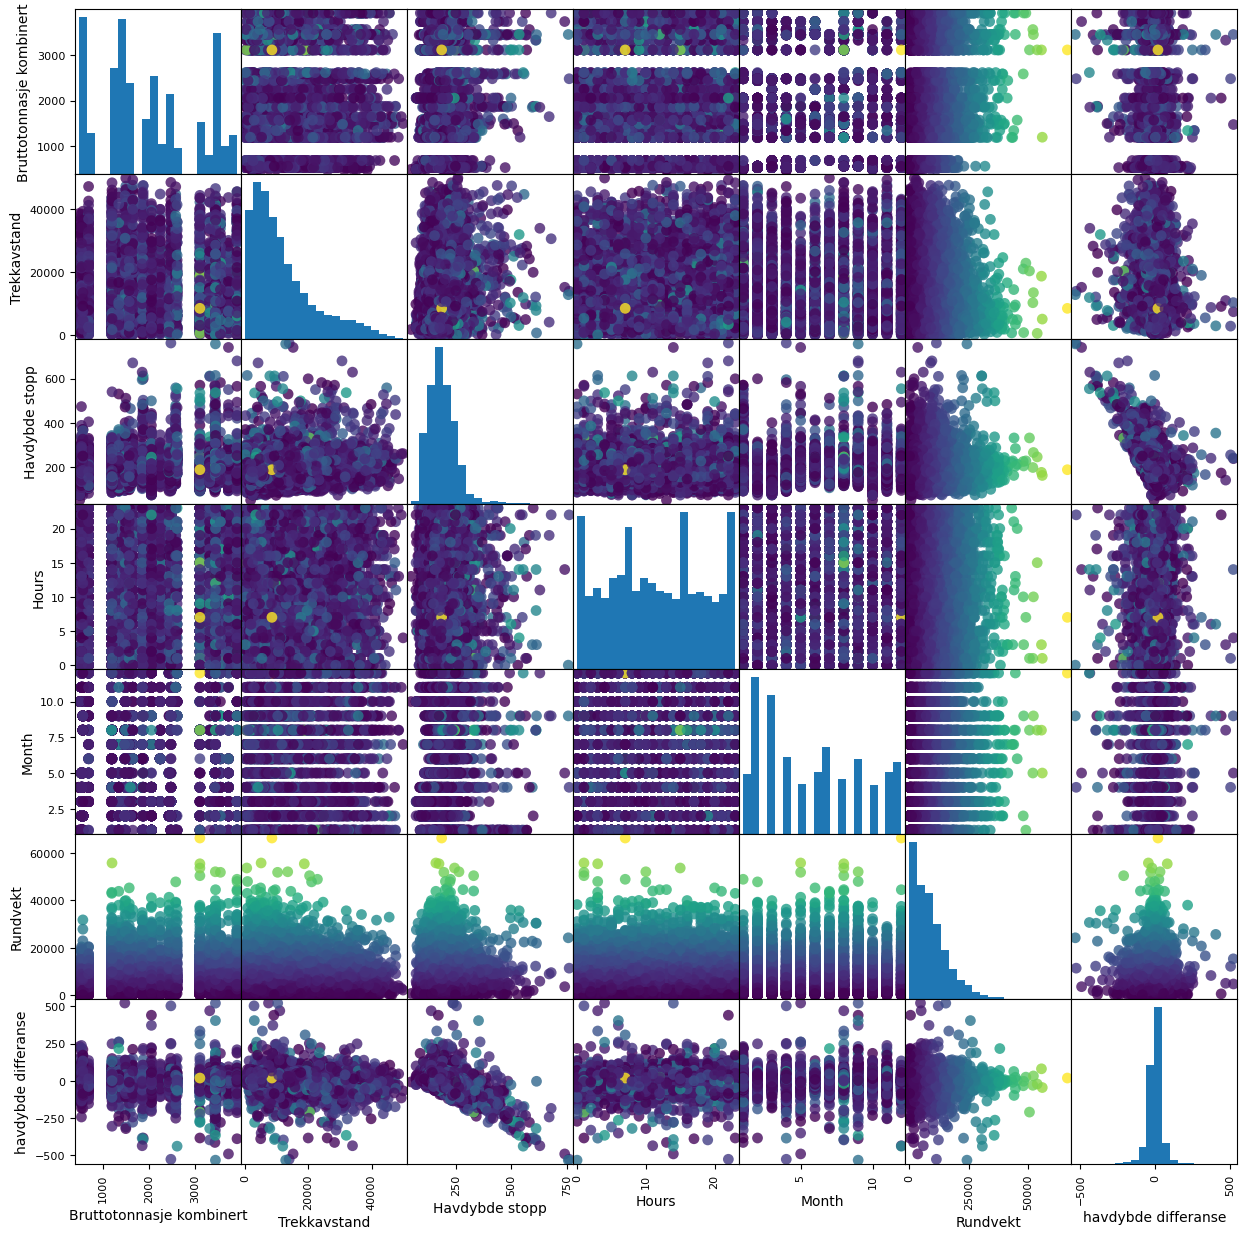

In [ ]:
cleaned_df = cleaned_df[cleaned_df['Rundvekt'] < 70000]
plot_frame = cleaned_df[all_features] 
grr = pd.plotting.scatter_matrix(
    plot_frame, c=plot_frame['Rundvekt'], figsize=(15, 15), marker='o', hist_kwds={'bins':20}, s=60, alpha=.8
    )


In [ ]:
# Step 3: Implement binning
labels = ['bad catch', 'Below Average', 'Above average', 'Good catch']

In [ ]:
# Binne target etter den logaritmiske kurven.
cleaned_df['log_Rundvekt'] = np.log1p(cleaned_df['Rundvekt'])  # Log-transform
cleaned_df['binned'] = pd.cut(cleaned_df['log_Rundvekt'], bins=4, labels=labels)
cleaned_df['binned'].value_counts()

binned
Good catch       4454
Above average    1835
Below Average     236
bad catch           3
Name: count, dtype: int64

In [ ]:
num_bins = 4  # For example, to create quartiles
labels = ['Q1', 'Q2', 'Q3', 'Q4']  # Labels for quartiles
cleaned_df['Q-binned'] = pd.qcut(cleaned_df['Rundvekt'], q=num_bins, labels=labels)
cleaned_df['Q-binned'].value_counts()

Q-binned
Q1    1632
Q2    1632
Q3    1632
Q4    1632
Name: count, dtype: int64

In [ ]:
# Kalkulerer gjennomsnittsrundvekten.
mean_catch_weight = cleaned_df['Rundvekt'].mean()
# Finner standardavviket.
std_dev_catch_weight = cleaned_df['Rundvekt'].std()

# Definerer bins, basert på standardavvik.
lower_bound = mean_catch_weight - 0.65*std_dev_catch_weight
upper_bound = mean_catch_weight + 1.5*std_dev_catch_weight


cleaned_df['fiske-kategori'] = pd.cut(cleaned_df['Rundvekt'], 
                                      bins=[-np.inf, lower_bound, mean_catch_weight, upper_bound, np.inf], 
                                      labels=labels)

print(std_dev_catch_weight)
print(mean_catch_weight)

# Display the first few rows to verify the binning
cleaned_df[['fiske-kategori']].value_counts()

7585.998262573925
8823.276807598038


fiske-kategori
Q3                2124
Q1                1952
Q2                1905
Q4                 547
Name: count, dtype: int64

In [ ]:
all_features = ['Startklokkeslett', 'Trekkavstand', 'Havdybde stopp', 'Hours', 'Month', 'Rundvekt', 'Bruttotonnasje kombinert', 'Startposisjon bredde', 'Startposisjon lengde']
features = ['Trekkavstand', 'Havdybde stopp', 'Startposisjon lengde', 'Startposisjon bredde', 'Bruttotonnasje kombinert']
target = 'fiske-kategori'
X = cleaned_df[features]
y = cleaned_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
# Scale features (for kNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  # Use transform, not fit_transform

# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=4)
knn_classifier.fit(X_train_scaled, y_train_encoded)
y_pred_knn_classifier = knn_classifier.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test_encoded, y_pred_knn_classifier)
print(f"KNN Classifier Accuracy: {accuracy}")
print(f'kNN Classifier Score {knn_classifier.score(X_test_scaled, y_test_encoded)}')

KNN Classifier Accuracy: 0.33614088820826954
kNN Classifier Score 0.33614088820826954


## 2.2 Desicion tree regressor


In [ ]:
cleaned_df.head()

,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Hovedområde start,Havdybde start,Havdybde stopp,Trekkavstand,Redskap FDIR,Hovedart - FDIR (kode),Rundvekt,Bruttotonnasje kombinert,Hours,Month,havdybde differanse,log_Rundvekt,binned,Q-binned,fiske-kategori
0,1900-01-01 18:54:00,61.283,2.074,28.0,Vikingbanken,-182,180,16590.0,Bunntrål,1032.0,3000.0,2053.0,18,1,2,8.006701,Above average,Q1,Q1
1,1900-01-01 18:10:00,68.261,10.842,5.0,Røstbanken til Malangsgrunnen,-385,558,44790.0,Bunntrål,1032.0,22432.0,2580.0,18,1,-173,10.018288,Good catch,Q4,Q4
2,1900-01-01 03:21:00,68.256,10.828,5.0,Røstbanken til Malangsgrunnen,-368,527,43775.0,Bunntrål,1032.0,9906.0,2580.0,3,1,-159,9.200997,Good catch,Q3,Q3
4,1900-01-01 19:25:00,68.318,11.036,5.0,Røstbanken til Malangsgrunnen,-353,386,25992.0,Bunntrål,1032.0,18538.0,2580.0,19,1,-33,9.827632,Good catch,Q4,Q3
5,1900-01-01 00:20:00,68.535,11.986,5.0,Røstbanken til Malangsgrunnen,-285,148,35125.0,Bunntrål,1032.0,17117.0,2580.0,0,1,137,9.747886,Good catch,Q4,Q3


In [ ]:
from sklearn.metrics import mean_absolute_error
# Endrer til rundvekt for flytende tallverdier.

target = 'Rundvekt'
y = cleaned_df[target]
# Splitter settet i trainsett og testsett - Da kan man sammenligne prediksjonene mot et test-sett
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
# Velger MLmodell
fishery_model = DecisionTreeRegressor(random_state=1)
# Trener(?) modellen på train-settet

fishery_model.fit(X_train, y_train)
# Prediksjoner - predikerer tar X-val verdiene og predikerer rundvekt basert på disse tallene.
val_predictions = fishery_model.predict(X_val)
# Sammenligner et utvalg (X-val.head()) av prediksjoner mot relaterte y_val.head()
print(fishery_model.predict(X_val.head()))
print(y_val.head())

# Tar inn y_val verdiene og regner ut gjennomsnittlig feil mellom prediksjonene og test-verdiene(val_y)
val_mae = mean_absolute_error(y_val, val_predictions)
print(f'\nMean absolute error: {val_mae}')
print(f'\nScore: {fishery_model.score(X_val, y_val)}\n')

[ 6250. 14702.  4523.  3294.  3997.]
3011     2279.0
6410    10323.0
3928     1007.0
3460     7007.0
5929     7748.0
Name: Rundvekt, dtype: float64

Mean absolute error: 7506.4716692189895

Score: -0.6214731723905189



## 2.3: Linear regression:


In [ ]:
data = cleaned_df[features]
predict = 'Rundvekt'

y = cleaned_df[predict]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

linear = linear_model.LinearRegression()
linear.fit(x_train, y_train)
score = linear.score(x_test, y_test)
print(score)

0.07022594987598074


## 2.4: MLP regressor


In [ ]:
#Columns removed for training of MLPRegressor neural network
# 'Meldingstidspunkt',
# 'Starttidspunkt',
# 'Startklokkeslett',
# 'Stopptidspunkt',
# 'Art - FDIR',
# 'Melding ID',
# 'Havdybde start',# Filter and remove incorrect values
# 'Havdybde stopp',# Filter and remove incorrect values
# 'Redskap FDIR (kode)', #Fjernet grunnet gjentagene data som ikke gav noe verdi
# #  'Bruttotonnasje Kombinert',
# 'Hovedart - FDIR (kode)', #Fjernet grunnet gjentagene data som ikke gav noe verdi
# 'Art - FDIR (kode)', #Fjernet grunnet gjentagene data som ikke gav noe verdi
# 'Art - gruppe (kode)', #Fjernet grunnet gjentagene data som ikke gav noe verdi

# Gruppere bruttotonnasje:
bins = [x for x in range(0, 4800, 100)] # Definerer gruppene
labels = range(1, len(bins))  # nummererer gruppene.
# Categorize 'Bruttotonnasje Kombinert' into the defined bins
cleaned_df['Bruttotonnasje Gruppert'] = pd.cut(cleaned_df['Bruttotonnasje kombinert'], bins=bins, labels=labels)
# Teller grupperingene
cleaned_df['Bruttotonnasje Gruppert'].value_counts()

Bruttotonnasje Gruppert
6     894
35    702
12    619
21    573
15    566
25    469
16    351
14    338
19    319
32    302
7     240
40    225
17    182
23    178
38    162
36    121
34    114
26     89
27     62
5      22
37      0
1       0
39      0
41      0
42      0
43      0
44      0
45      0
46      0
33      0
24      0
31      0
30      0
29      0
28      0
2       0
22      0
20      0
18      0
13      0
11      0
10      0
9       0
8       0
4       0
3       0
47      0
Name: count, dtype: int64

In [ ]:
print(cleaned_df.shape)
cleaned_df.head()
y = cleaned_df['Rundvekt'] 
X = cleaned_df.drop('Rundvekt', axis=1) #Dropping rundvekt since that's what i'm training the model on


(6528, 20)


In [ ]:
from sklearn.datasets import make_regression
# X = df.drop('Rundvekt', axis=1)
# y = df['Rundvekt']
X, y = make_regression(n_samples=200, random_state=1) #Might make it overfit!
# print(X,y)

In [ ]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X,y, random_state= 1235)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
#MinMax Scaler works best with MLPRegressor

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.fit_transform(X_test)

# print(X)

In [ ]:
#Turns out standard scaler does horrible tings to MLPregressor! it does best with values between 0 and 1

# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()

# scaler = sc.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(hidden_layer_sizes = [20,10], #First hidden layer has 20 neurons, second hidden layer has 10 neurons
                  activation = 'relu', alpha = 0.1, 
                  max_iter = 2000, #Max iterations you do. AKA max epocs
                #   early_stopping=True, #Can't use early stopping due to massive loss values in Rundvekt
                #   tol=
                  learning_rate_init=0.1,#Initial learning rate, adaptive adapts this learning rate to minimize loss
                  learning_rate="adaptive",
                  solver = 'adam', 
                  verbose = False)
#activation logistic tanh relu identity
#solver adam lbfgs sgd 

In [ ]:
#Test score without data leak. (using minmax after splitting)
# nn.fit(X_train, y_train)
nn.fit(X_train_minmax, y_train)
print("Neural network, MLPRegressor")
print("Test score",  nn.score(X_test_minmax, y_test))
print("Train  score", nn.score(X_train_minmax, y_train)) #Fix training score, might be wrong due to testing on training data


# print("Neural network, MLPRegressor")
# print("Test score",  nn.score(X_test, y_test))
# print("Train  score", nn.score(X_train, y_train)) #Fix training score, might be wrong due to testing on training data

# print("FIXED???? Neural network, MLPRegressor")
# print("Test score",  nn.score(X_test_scaled, y_test))
# print("Train  score", nn.score(X_train_scaled, y_train)) #Fix training score, might be wrong due to testing on training data

Neural network, MLPRegressor
Test score -0.5094356005487619
Train  score 0.8370598724524236


Oppsummering: https://stackoverflow.com/questions/62131266/mlpregressor-working-but-results-dont-make-any-sense It doesn't make any sense to predict on your training data. That provides no value, as it is testing the same data it learned from and should predict 100%. That is an example of

important and relevant properties of the data how you preprocessed data like which features you selected, did you do dimension reduction, how you reformatted data, etc. how you decided on parameters for your machine learning models, if you used any regularization techniques? In case how. how the methods were measured and compared

Turns out trying a max_iter of 1000 was a bit dumb! It wasnt enough iterations for the model to become optimized (converge) To fix it i changed max_iter to 5000 and realized that max_iter isn't the amount of iterations you do! it's the max amount of iterations you do. I feel dumb Iterations will be 5000 unless stated otherwise

With 5000 max iterations Test score 0.15868380817426364 Train score 0.2402524144823477

With 1000 max iterations Test score 0.023895760424976542 Train score 0.044879597360761636

Test 2 removed 'Redskap FDIR (kode)', 'Bruttotonnasje Kombinert', Test score 0.22802640821841036 Train score 0.17609209269226367 Eval: Turns out bruttotonnasje is important for amount of fish caught. I can't say i'm surprised

Test 3 max_iter = 10 000 Re-added 'Bruttotonnasje Kombinert' Kept 'Redskap FDIR (kode)' Turns out 5000 iterations wasn't enough! this will hopefully mean we have a smaller loss value and can thus get a higher accuracy as it converges better! Changed to 10 000 iterations max Test score 0.2183750907000509 Train score 0.22780564641998635 The training score seems to have increased! Running it again made Test score = 0.15405352930651073. Removing it seems to cause instability. i will keep it for now

Test 3 added a regression thingy and increased to 100 000 iterations (can probobaly lower it to 10 000 now) Test score 0.3805415453308878 Train score 0.9885294076382664 Obviously overtrained! but the test score is getting better!

Test 4 Fjernet: Hovedart - FDIR (kode) Art - FDIR (kode) Art - gruppe (kode) Dette er grunnet at disse verdiene ikke gav mye unik informasjon å lære fra.

Test score 0.4551050579085447 Train score 0.9926394850239878 Minimal økning, det var i alle fall ingen nedtur i nøyaktigheten. men den er enda overfitted

Max_iter = 1000 removed: Melding ID Test score 0.038746802791864265 Train score 0.04016411056751845

Max_iter = 1000 Test score 0.02857554746080171 Train score 0.04388748121910424 Changing iter to 1000 with a good score is the goal!

V2, removed linear regression thingy Max_iter = 5000 Test score 0.18474766635857465 Train score 0.26563262873718185

Without removed collumns Test score 0.03306077219837722 Train score 0.07260871122128132

with removed collumnds (linear regression collumns) Test score 0.034291607331412455 Train score 0.07651381759634102

# 3: Unsupervised learning
